## Microbusiness Density Forecasting

👉 This study will examine the dataset named as **"Microbusiness Density Forecasting"** at Kaggle website [external link text](https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting).


The goal of this work to predict monthly microbusiness density in a given area. You will develop an accurate model trained on U.S. county-level data.

Works on data will help policymakers gain visibility into microbusinesses, a growing trend of very small entities. Additional information will enable new policies and programs to improve the success and impact of these smallest of businesses.

Let's forecast microbusiness activity across the United States, as measured by the density of microbusinesses in US counties. Microbusinesses are often too small or too new to show up in traditional economic data sources, but microbusiness activity may be correlated with other economic indicators of general interest.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

# Data view

In [99]:
df = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv")
df1= pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv")

In [100]:
df.isnull().sum()

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
dtype: int64

In [38]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [101]:
df.first_day_of_month = pd.to_datetime(pd.Series(df.first_day_of_month))
df["month"]=df.first_day_of_month.dt.month
df["year"]=df.first_day_of_month.dt.year


In [28]:
df.sample()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,month,year
2170,1111_2021-09-01,1111,Randolph County,Alabama,2021-09-01,2.681539,476,9,2021


In [103]:
df.drop(["first_day_of_month","row_id","county","state"],axis=1,inplace=True)

KeyError: "['first_day_of_month' 'row_id' 'county' 'state'] not found in axis"

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cfips                  122265 non-null  int64  
 1   microbusiness_density  122265 non-null  float64
 2   active                 122265 non-null  int64  
 3   month                  122265 non-null  int64  
 4   year                   122265 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 4.7 MB


In [31]:
#df=pd.get_dummies(df,drop_first=True)

**The third dataset related this project is below.**

In [105]:
census_starter_df =pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv")

In [106]:
census_starter_df.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [107]:
for i in census_starter_df.columns:
    if i == "cfips":
        pass
    else:
        census_starter_df[i] = np.log(census_starter_df[i]+1)
census_starter_df.head()
 

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,4.351567,4.380776,4.401829,4.427239,4.460144,1001,2.740840,2.827314,2.839078,2.873565,...,0.832909,0.741937,0.530628,0.470004,0.741937,10.920854,10.981676,10.980740,10.967905,11.045495
1,4.324133,4.370713,4.416428,4.455509,4.487512,1003,3.063391,3.077312,3.091042,3.054001,...,0.875469,0.832909,0.875469,0.693147,0.832909,10.869768,10.932446,10.973718,11.030963,11.072046
2,4.063885,4.117410,4.119037,4.183576,4.183576,1005,2.151762,2.174752,2.151762,2.116256,...,0.405465,0.262364,0.587787,0.741937,0.587787,10.415383,10.439601,10.389795,10.462846,10.502956
3,4.143135,4.206184,4.251348,4.345103,4.325456,1007,2.208274,2.151762,2.014903,2.128232,...,0.788457,0.875469,0.955511,0.993252,1.131402,10.678330,10.721967,10.769390,10.853639,10.901874
4,4.201703,4.241327,4.304065,4.389499,4.406719,1009,2.272126,2.208274,2.261763,2.292535,...,0.832909,0.875469,0.641854,0.741937,0.641854,10.766652,10.793352,10.806875,10.798003,10.874853


In [108]:
merged_train_df = pd.merge(df, census_starter_df, how = 'left', on = 'cfips')
merged_train_df

,cfips,microbusiness_density,active,month,year,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001,3.007682,1249,8,2019,4.351567,4.380776,4.401829,4.427239,4.460144,...,0.832909,0.741937,0.530628,0.470004,0.741937,10.920854,10.981676,10.980740,10.967905,11.045495
1,1001,2.884870,1198,9,2019,4.351567,4.380776,4.401829,4.427239,4.460144,...,0.832909,0.741937,0.530628,0.470004,0.741937,10.920854,10.981676,10.980740,10.967905,11.045495
2,1001,3.055843,1269,10,2019,4.351567,4.380776,4.401829,4.427239,4.460144,...,0.832909,0.741937,0.530628,0.470004,0.741937,10.920854,10.981676,10.980740,10.967905,11.045495
3,1001,2.993233,1243,11,2019,4.351567,4.380776,4.401829,4.427239,4.460144,...,0.832909,0.741937,0.530628,0.470004,0.741937,10.920854,10.981676,10.980740,10.967905,11.045495
4,1001,2.993233,1243,12,2019,4.351567,4.380776,4.401829,4.427239,4.460144,...,0.832909,0.741937,0.530628,0.470004,0.741937,10.920854,10.981676,10.980740,10.967905,11.045495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045,1.803249,101,6,2022,4.278054,4.308111,4.354141,4.390739,4.410371,...,0.470004,0.470004,0.000000,0.000000,0.000000,10.995512,10.875554,10.951368,10.884329,11.090828
122261,56045,1.803249,101,7,2022,4.278054,4.308111,4.354141,4.390739,4.410371,...,0.470004,0.470004,0.000000,0.000000,0.000000,10.995512,10.875554,10.951368,10.884329,11.090828
122262,56045,1.785395,100,8,2022,4.278054,4.308111,4.354141,4.390739,4.410371,...,0.470004,0.470004,0.000000,0.000000,0.000000,10.995512,10.875554,10.951368,10.884329,11.090828
122263,56045,1.785395,100,9,2022,4.278054,4.308111,4.354141,4.390739,4.410371,...,0.470004,0.470004,0.000000,0.000000,0.000000,10.995512,10.875554,10.951368,10.884329,11.090828


In [110]:
merged_train_df=merged_train_df.fillna(0)

In [111]:
merged_train_df.isnull().sum()

cfips                    0
microbusiness_density    0
active                   0
month                    0
year                     0
pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              0
pct_bb_2021              0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         0
pct_college_2021         0
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    0
pct_foreign_born_2021    0
pct_it_workers_2017      0
pct_it_workers_2018      0
pct_it_workers_2019      0
pct_it_workers_2020      0
pct_it_workers_2021      0
median_hh_inc_2017       0
median_hh_inc_2018       0
median_hh_inc_2019       0
median_hh_inc_2020       0
median_hh_inc_2021       0
dtype: int64

In [80]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122265 entries, 0 to 122264
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cfips                  122265 non-null  int64  
 1   microbusiness_density  122265 non-null  float64
 2   active                 122265 non-null  int64  
 3   month                  122265 non-null  int64  
 4   year                   122265 non-null  int64  
 5   pct_bb_2017            122265 non-null  float64
 6   pct_bb_2018            122265 non-null  float64
 7   pct_bb_2019            122265 non-null  float64
 8   pct_bb_2020            122265 non-null  float64
 9   pct_bb_2021            122265 non-null  float64
 10  pct_college_2017       122265 non-null  float64
 11  pct_college_2018       122265 non-null  float64
 12  pct_college_2019       122265 non-null  float64
 13  pct_college_2020       122265 non-null  float64
 14  pct_college_2021       122265 non-nu

In [113]:
x = merged_train_df.drop("microbusiness_density",axis=1)
y = merged_train_df["microbusiness_density"]

In [87]:
#x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=42)

# Multi Regression

In [114]:
def regression_funct(x,y):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Ridge,Lasso
    from sklearn.linear_model import ElasticNet
    from sklearn.tree import ExtraTreeRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.neighbors import KNeighborsRegressor
    
    from sklearn.model_selection import train_test_split

    from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

    L=LinearRegression()
    R=Ridge()
    Lass=Lasso()
    E=ElasticNet()
    ExTree=ExtraTreeRegressor()
    GBR=GradientBoostingRegressor()
    KN=KNeighborsRegressor()
    
    algos=[L,R,Lass,E,ExTree,GBR,KN]
    algo_names=['LinearRegression','Ridge','Lasso','ElasticNet','ExtraTreeRegressor','GradientBoostingRegressor','KNeighborsRegressor']
    r_squared=[]
    rmse=[]
    mae=[]
    
    result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
    
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
    
    for item in algos:
        item.fit(x_train,y_train)
        item.predict(x_test)
        r_squared.append(r2_score(y_test,item.predict(x_test)))
        rmse.append((mean_squared_error(y_test,item.predict(x_test)))**.5)
        mae.append(mean_absolute_error(y_test,item.predict(x_test)))
        
    result.R_Squared=r_squared
    result.RMSE=rmse
    result.MAE=mae
        
    return result.sort_values('R_Squared',ascending=False)

In [115]:
regression_funct(x,y)

,R_Squared,RMSE,MAE
ExtraTreeRegressor,0.998531,0.186256,0.033750
KNeighborsRegressor,0.787014,2.242878,0.318488
GradientBoostingRegressor,0.773595,2.312452,1.019779
LinearRegression,0.287813,4.101349,1.602864
Ridge,0.287801,4.101383,1.602670
ElasticNet,0.158064,4.459327,1.963278
Lasso,0.101992,4.605426,2.163075


# Deep Learning

In [88]:
model=Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mse')#mse regression

In [89]:
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=128, epochs=50, verbose=1)

Epoch 1/50
765/765 [==============================] - 4s 4ms/step - loss: 13335.1182 - val_loss: 19.2104
Epoch 2/50
765/765 [==============================] - 3s 4ms/step - loss: 33.7089 - val_loss: 17.0439
Epoch 3/50
765/765 [==============================] - 3s 3ms/step - loss: 34.0348 - val_loss: 21.9382
Epoch 4/50
765/765 [==============================] - 3s 4ms/step - loss: 25.5096 - val_loss: 16.5921
Epoch 5/50
765/765 [==============================] - 3s 4ms/step - loss: 19.0759 - val_loss: 16.2611
Epoch 6/50
765/765 [==============================] - 3s 4ms/step - loss: 18.9140 - val_loss: 15.7381
Epoch 7/50
765/765 [==============================] - 3s 4ms/step - loss: 56.3009 - val_loss: 16.1484
Epoch 8/50
765/765 [==============================] - 3s 4ms/step - loss: 17.6330 - val_loss: 16.1690
Epoch 9/50
765/765 [==============================] - 3s 4ms/step - loss: 17.7824 - val_loss: 16.4943
Epoch 10/50
765/765 [==============================] - 3s 4ms/step - loss: 18.1

In [90]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 512)               15360     
_________________________________________________________________
dense_33 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_36 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_37 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_38 (Dense)             (None, 512)              

<AxesSubplot:>

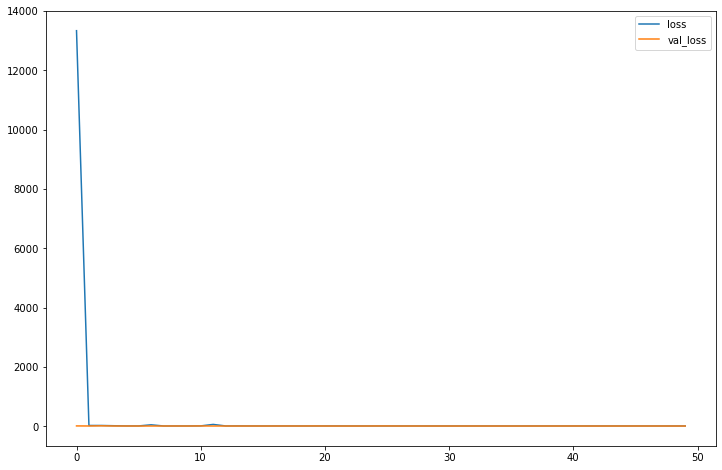

In [91]:
loss_df=pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))

In [19]:
#df1.info()

In [20]:
#df1.first_day_of_month = pd.to_datetime(pd.Series(df1.first_day_of_month))
#df1["month"]=df1.first_day_of_month.dt.month
#df1["year"]=df1.first_day_of_month.dt.year
#df1.drop(["first_day_of_month","row_id"],axis=1,inplace=True)

In [21]:
#df1=pd.get_dummies(df1,drop_first=True)

In [92]:
pred=model.predict(x_test)

In [93]:
(mean_squared_error(y_test,pred))**.5

3.9583025769029923

In [95]:
r2_score(y_test,pred) 

0.3366256893740135